In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from preprocessing import *

In [2]:
# Vérification du dossier de résultats
os.makedirs('results', exist_ok=True)

In [3]:
# Charger les fichiers
X_file = "data/X_matrix_preprocessed.csv"
Y_file = "data/Y_matrix_preprocessed.csv"

print("Chargement des données...")
X = pd.read_csv(X_file)
Y = pd.read_csv(Y_file)

Chargement des données...


In [21]:
# Assurez-vous que les Yeast_ID sont des chaînes
X['Yeast_ID'] = X['Yeast_ID'].astype(str)
Y['Yeast_ID'] = Y['Yeast_ID'].astype(str)

# Vérifiez que les Yeast_ID sont alignés
print("Vérification de l'ordre des Yeast_ID...")
if not all(X["Yeast_ID"] == Y["Yeast_ID"]):
    raise ValueError("L'ordre des Yeast_ID ne correspond pas entre les deux fichiers.")

Vérification de l'ordre des Yeast_ID...


In [4]:
print("Prétraitement des données...")
X = X.drop(columns=["Yeast_ID"]).fillna(0)
Y = Y.drop(columns=["Yeast_ID"]).fillna(Y.drop(columns=["Yeast_ID"]).mean())
#X, Y = preprocessed_data(X, Y)

Prétraitement des données...


In [5]:
# Affichage des dimensions après prétraitement
print(f"Dimensions après prétraitement : X={X.shape}, Y={Y.shape}")

# Aperçu des données après prétraitement
print("Aperçu des premières lignes des données après prétraitement :")
print(X.head())
print(Y.head())

Dimensions après prétraitement : X=(792, 334399), Y=(792, 1)
Aperçu des premières lignes des données après prétraitement :
   YAL001C_1002_P->L  YAL001C_1011_I->V  YAL001C_1022_D->Y  YAL001C_1027_V->M  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   YAL001C_102_K->R  YAL001C_1031_R->L  YAL001C_1039_R->K  YAL001C_1047_P->A  \
0                 0                  0                  0                  0   
1                 0                  0                  0                  0   
2                 0                  0                  0                  0   
3                 0                  0                  0             

In [6]:
# Division des données en ensembles d'entraînement et de test
print("Division des données en ensembles d'entraînement et de test...")
sss = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_index, test_index = next(sss.split(X, Y))

X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
y_train, y_test = Y.iloc[train_index, :], Y.iloc[test_index, :]

# Affichage des dimensions des ensembles divisés
print(f"Dimensions de X_train : {X_train.shape}, X_test : {X_test.shape}")
print(f"Dimensions de y_train : {y_train.shape}, y_test : {y_test.shape}")

Division des données en ensembles d'entraînement et de test...
Dimensions de X_train : (594, 334399), X_test : (198, 334399)
Dimensions de y_train : (594, 1), y_test : (198, 1)


In [7]:
# Vérifiez les valeurs NaN ou inf dans X_train et X_test
print("Valeurs NaN dans X_train :", np.isnan(X_train).sum().sum())
print("Valeurs NaN dans X_test :", np.isnan(X_test).sum().sum())
print("Valeurs inf dans X_train :", np.isinf(X_train).sum().sum())
print("Valeurs inf dans X_test :", np.isinf(X_test).sum().sum())

Valeurs NaN dans X_train : 0
Valeurs NaN dans X_test : 0
Valeurs inf dans X_train : 0
Valeurs inf dans X_test : 0


In [8]:
print("Définition des paramètres pour la recherche aléatoire...")
GBM_distributions = dict(
    max_features=["auto", "log2", "sqrt"],
    learning_rate=uniform(1e-3, 1),
    subsample=uniform(0, 1),
    min_samples_split=randint(2, 100),
    min_samples_leaf=randint(2, 100),
    n_estimators=randint(10, 200),
    criterion=['friedman_mse', 'squared_error'],
    max_depth=randint(2, 10)
)

Définition des paramètres pour la recherche aléatoire...


In [9]:
# Entraînement multitâche avec RandomizedSearchCV
print("Lancement de l'entraînement multitâche avec Gradient Boosting...")
n_iterations = 100
cross_val = 3
num_jobs = -1

multireg = MultiOutputRegressor(RandomizedSearchCV(
    GradientBoostingRegressor(loss="squared_error", n_iter_no_change=5),
    GBM_distributions,
    n_iter=n_iterations,
    verbose=10,
    cv=cross_val,
    n_jobs=num_jobs
)).fit(X_train, y_train)

Lancement de l'entraînement multitâche avec Gradient Boosting...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3; 1/100] START criterion=squared_error, learning_rate=0.7666671781446204, max_depth=4, max_features=sqrt, min_samples_leaf=92, min_samples_split=87, n_estimators=94, subsample=0.1771214339078847
[CV 1/3; 1/100] START criterion=squared_error, learning_rate=0.7666671781446204, max_depth=4, max_features=sqrt, min_samples_leaf=92, min_samples_split=87, n_estimators=94, subsample=0.1771214339078847
[CV 3/3; 1/100] START criterion=squared_error, learning_rate=0.7666671781446204, max_depth=4, max_features=sqrt, min_samples_leaf=92, min_samples_split=87, n_estimators=94, subsample=0.1771214339078847
[CV 1/3; 2/100] START criterion=squared_error, learning_rate=0.3558455176874382, max_depth=3, max_features=log2, min_samples_leaf=53, min_samples_split=49, n_estimators=98, subsample=0.07697786906624737
[CV 2/3; 2/100] START criterion=squared_error, learning_rate=0.

In [10]:
# Prédictions
print("Prédictions sur les données de test...")
y_pred = multireg.predict(X_test)

Prédictions sur les données de test...


In [12]:
# Sauvegarde des résultats
y_test_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=Y.columns)
y_test_pred_df.to_csv('results/y_test_predicted_multitarget_GBM.csv')

In [14]:
# Importance des caractéristiques
print("Calcul des importances des caractéristiques...")
feature_importances = []
for estimator in multireg.estimators_:
    best_estimator = estimator.best_estimator_
    importances = best_estimator.feature_importances_
    feature_importances.append(importances)

# Moyenne des importances
average_feature_importances = pd.DataFrame(feature_importances).mean(axis=0)
feature_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": average_feature_importances
}).sort_values(by="Importance", ascending=False)
feature_importances_df.to_csv('results/feature_importances_multitarget_GBM.csv')

# Affichage des résultats
print("Enregistrement terminé. Les résultats sont sauvegardés dans le dossier 'results'.")

Calcul des importances des caractéristiques...
Enregistrement terminé. Les résultats sont sauvegardés dans le dossier 'results'.


In [15]:
# Calcul des métriques
print("Calcul des métriques...")
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.6f}")

Calcul des métriques...
Mean Squared Error: 0.040373
R² Score: -0.001826


Calcul de l'importance des caractéristiques...

Mutations ayant le plus d'impact sur le YPD doubling time :
                  Feature  Importance
55888     YDR069C_95_V->I    0.102878
134446  YGR270W_1153_K->E    0.083811
163596    YIR028W_57_S->C    0.070123
8481    YBL047C_1108_K->N    0.062255
334366            PCA_238    0.059960
163114   YIR021W_264_G->D    0.057029
331075   YPL272C_315_A->V    0.053794
88624   YER038W-A_83_T->A    0.043573
48199   YDL171C_1631_L->R    0.039763
330602   YPL260W_524_G->D    0.036579


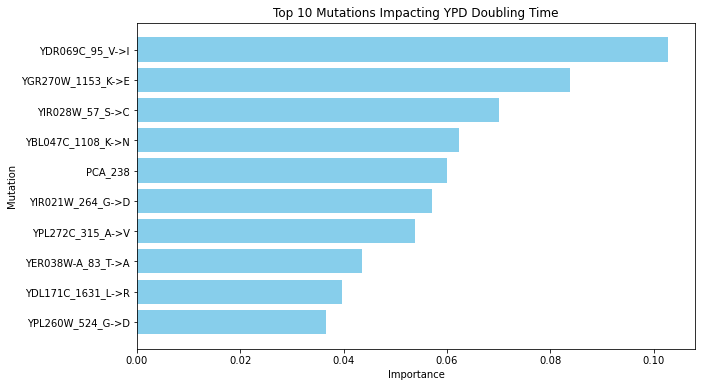

In [16]:
# Importance des caractéristiques
print("Calcul de l'importance des caractéristiques...")
top_mutations = feature_importances_df.head(10)
print("\nMutations ayant le plus d'impact sur le YPD doubling time :")
print(top_mutations)

plt.figure(figsize=(10, 6))
plt.barh(top_mutations["Feature"], top_mutations["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Mutation")
plt.title("Top 10 Mutations Impacting YPD Doubling Time")
plt.gca().invert_yaxis()
plt.show()

In [17]:
print("Les résultats sont sauvegardés dans le dossier 'results/'.")

Les résultats sont sauvegardés dans le dossier 'results/'.


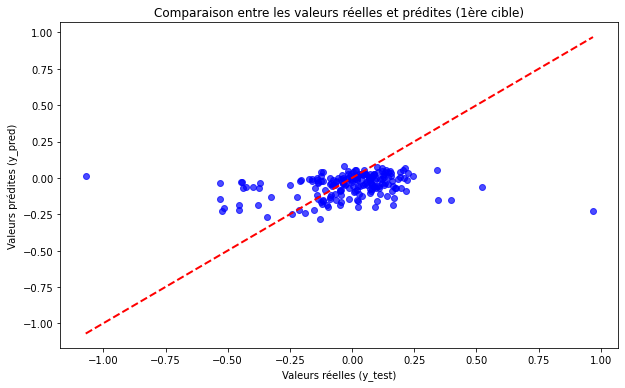

In [18]:
# Comparaison des valeurs réelles et prédites pour une des cibles (exemple : première colonne de y_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test.iloc[:, 0], y_pred[:, 0], alpha=0.7, color='blue')
plt.plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()],
         [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Valeurs réelles (y_test)')
plt.ylabel('Valeurs prédites (y_pred)')
plt.title("Comparaison entre les valeurs réelles et prédites (1ère cible)")
plt.show()

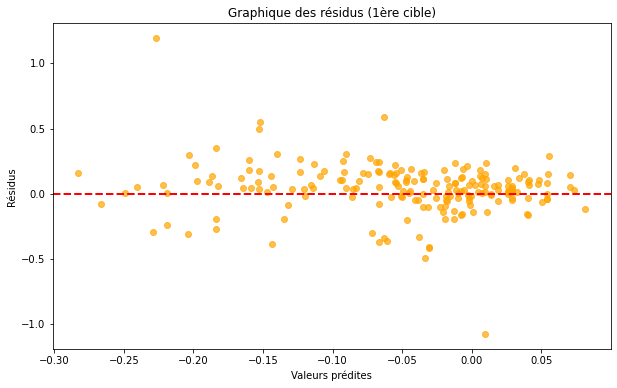

In [19]:
# Calcul des résidus pour la première cible
residuals = y_test.iloc[:, 0] - y_pred[:, 0]

plt.figure(figsize=(10, 6))
plt.scatter(y_pred[:, 0], residuals, alpha=0.7, color='orange')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title("Graphique des résidus (1ère cible)")
plt.show()

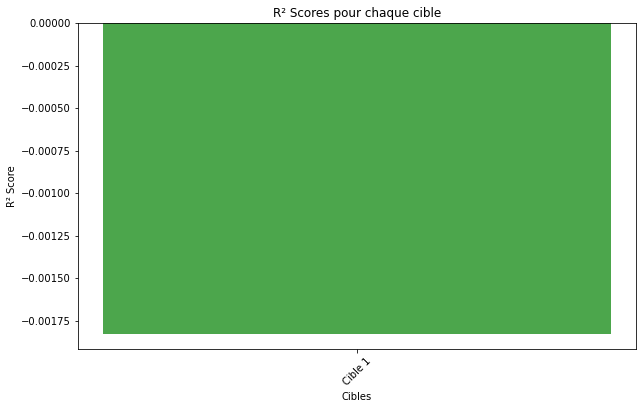

In [20]:
# Calcul des R² pour chaque colonne
r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(len(r2_scores)), r2_scores, color='green', alpha=0.7)
plt.xlabel("Cibles")
plt.ylabel("R² Score")
plt.title("R² Scores pour chaque cible")
plt.xticks(range(len(r2_scores)), [f"Cible {i+1}" for i in range(len(r2_scores))], rotation=45)
plt.show()